# Evaluación de modelos entrenados

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib
from sklearn.multioutput import MultiOutputRegressor
import os

## Carga de datos

In [ ]:
script_path = os.path.dirname(os.path.realpath(__file__))
dataset_train = np.load(script_path+"/rf_datasets/train_data_no_norm.npz")
dataset_val = np.load(script_path+"/rf_datasets/val_data_no_norm.npz")

X_train = dataset_train['X'].astype(np.float32)
y_train = dataset_train['Y'].astype(np.float32)
X_val = dataset_val['X'].astype(np.float32)
y_val = dataset_val['Y'].astype(np.float32)

print("y shape", y_train.shape)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

base_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    n_jobs=-1
    # Add more parameters if needed
)
model = MultiOutputRegressor(base_model)

# Fit the model
model.fit(X_train, y_train)

# Optional: evaluate
score = model.score(X_val, y_val)
print("Validation R^2 score:", score)

# Save the model
joblib.dump(model, script_path+"/light_models/"+'light_model1.pkl')


In [17]:
# Test/Train split #
####################
target_day = '2025-02-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_index = indices[0]
print(df.iloc[first_2025_index])

time                    2025-02-01 00:00:00+00:00
air_temperature                         15.057615
atmospheric_pressure                   987.076619
relative_humidity                       77.964722
sin_day                                       0.0
cos_day                                       1.0
sin_year                                 0.508671
cos_year                                 0.860961
Name: 16872, dtype: object


In [18]:
train_data = df.loc[0 : first_2025_index].reset_index(drop=True)
val_data = df.loc[first_2025_index:].reset_index(drop=True)

print(train_data.head())
print(val_data.head())

                       time  air_temperature  atmospheric_pressure  \
0 2023-03-01 00:00:00+00:00        16.781813            981.684957   
1 2023-03-01 01:00:00+00:00        16.627038            981.290955   
2 2023-03-01 02:00:00+00:00        16.322283            980.870178   
3 2023-03-01 03:00:00+00:00        15.971193            980.187887   
4 2023-03-01 04:00:00+00:00        15.535278            979.789154   

   relative_humidity   sin_day   cos_day  sin_year  cos_year  
0          79.808440  0.000000  1.000000  0.849817  0.527078  
1          80.590277  0.258819  0.965926  0.850195  0.526468  
2          86.238889  0.500000  0.866025  0.850572  0.525858  
3          86.658054  0.707107  0.707107  0.850949  0.525248  
4          87.983887  0.866025  0.500000  0.851326  0.524637  
                       time  air_temperature  atmospheric_pressure  \
0 2025-02-01 00:00:00+00:00        15.057615            987.076619   
1 2025-02-01 01:00:00+00:00        15.112812            986.7

In [19]:
data = {}
targets = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for target in targets:
  data[target] = {
    "train": train_data[target],
    "val": val_data[target],
  }

VARIABLE:  air_temperature
                               SARIMAX Results                                
Dep. Variable:        air_temperature   No. Observations:                16873
Model:                ARIMA(30, 1, 0)   Log Likelihood              -14179.559
Date:                Thu, 03 Apr 2025   AIC                          28421.119
Time:                        13:43:04   BIC                          28660.854
Sample:                             0   HQIC                         28500.204
                              - 16873                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1681      0.003     53.764      0.000       0.162       0.174
ar.L2         -0.0987      0.005    -20.149      0.000      -0.108      -0.089
ar.L3         -0.0918    

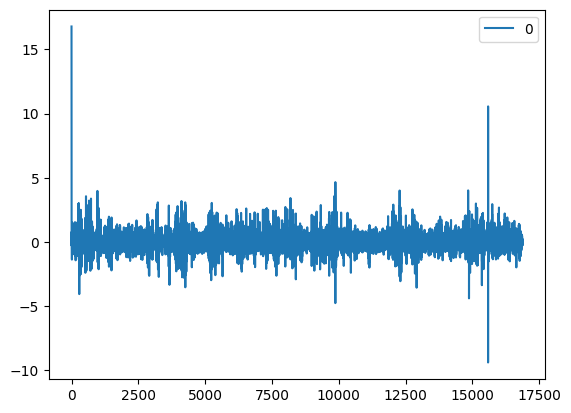

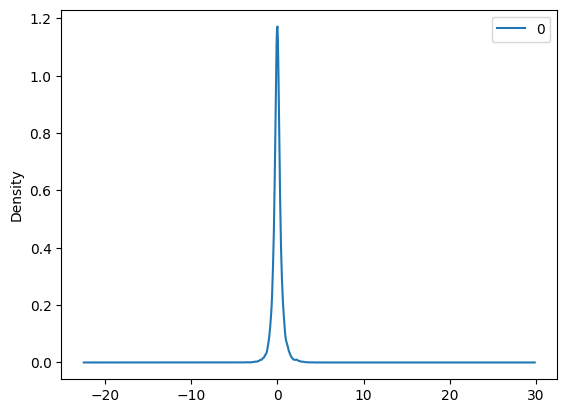

                  0
count  16873.000000
mean       0.000861
std        0.575406
min       -9.394491
25%       -0.248818
50%       -0.015924
75%        0.224716
max       16.781813
VARIABLE:  relative_humidity
                               SARIMAX Results                                
Dep. Variable:      relative_humidity   No. Observations:                16873
Model:                ARIMA(30, 1, 0)   Log Likelihood              -49581.116
Date:                Thu, 03 Apr 2025   AIC                          99224.232
Time:                        13:43:54   BIC                          99463.967
Sample:                             0   HQIC                         99303.317
                              - 16873                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a

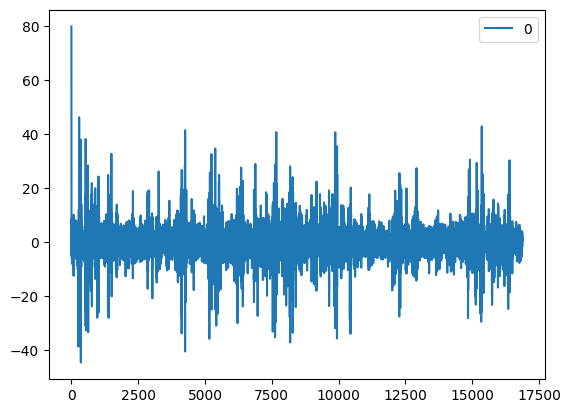

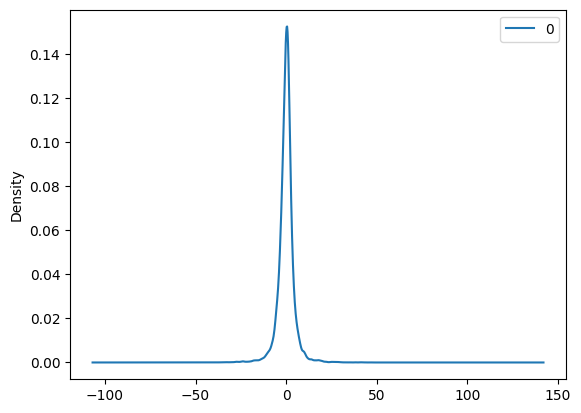

                  0
count  16873.000000
mean       0.004073
std        4.612025
min      -44.640691
25%       -1.795972
50%        0.156407
75%        1.819698
max       79.808440
VARIABLE:  atmospheric_pressure
                                SARIMAX Results                                 
Dep. Variable:     atmospheric_pressure   No. Observations:                16873
Model:                  ARIMA(30, 1, 0)   Log Likelihood                3723.621
Date:                  Thu, 03 Apr 2025   AIC                          -7385.243
Time:                          13:44:40   BIC                          -7145.507
Sample:                               0   HQIC                         -7306.158
                                - 16873                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

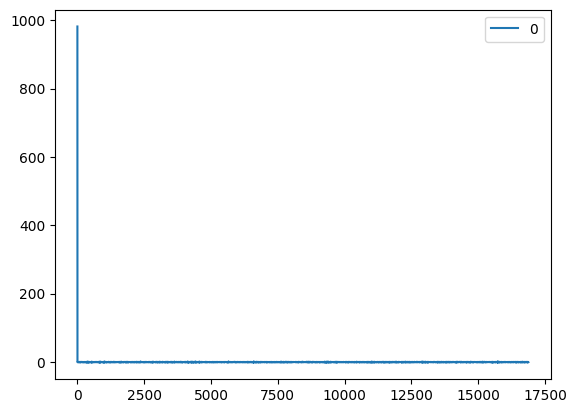

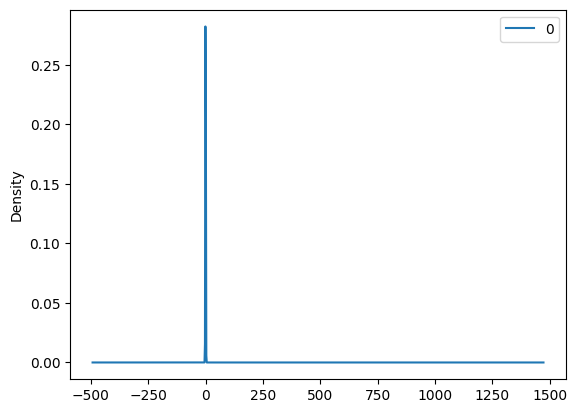

                  0
count  16873.000000
mean       0.058242
std        7.559952
min       -1.274047
25%       -0.119867
50%        0.000154
75%        0.118371
max      981.684957


In [20]:
for target in targets:
  model = ARIMA(data[target]["train"], order=(30,1,0))
  model_fit = model.fit()

  # summary of fit model
  print("VARIABLE: ", target)
  print(model_fit.summary())
  # line plot of residuals
  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  plt.show()
  # density plot of residuals
  residuals.plot(kind='kde')
  plt.show()
  # summary stats of residuals
  print(residuals.describe())

In [21]:
target = "air_temperature"

history = [x for x in data[target]["train"]]
test = data[target]["val"]

predicted_values = []
actual_values = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(30,1,0))
    model_fit = model.fit()
    
    # Forecast the next 3 steps
    output = model_fit.forecast(steps=3)
    
    # Store the forecasted values
    predicted_values.extend(output)  # Append all 3 predicted values
    
    # Store the actual observed values for comparison
    actual_values.extend(test.iloc[t:t+3].values)  # Next 3 actual values from test set
    
    # Update history with the actual observed value
    obs = test.iloc[t]
    history.append(obs)
    
    # Print the predicted and expected values for the current step
    print('predicted=%f, expected=%f' % (output[0], obs))

predicted=14.997868, expected=15.057615
predicted=14.975328, expected=15.112812
predicted=15.036605, expected=15.155929
predicted=15.072839, expected=14.865313
predicted=14.767682, expected=14.508893
predicted=14.460422, expected=14.897954
predicted=15.083397, expected=14.624181
predicted=14.781267, expected=14.545105
predicted=14.912378, expected=14.892415
predicted=15.392221, expected=15.540823
predicted=15.991556, expected=15.752582
predicted=16.036349, expected=16.368972
predicted=16.646868, expected=17.131702
predicted=17.293491, expected=17.788147
predicted=17.776840, expected=17.704058
predicted=17.401984, expected=17.656048
predicted=17.237671, expected=16.884825
predicted=16.340611, expected=16.721510
predicted=16.437671, expected=16.323222
predicted=16.035766, expected=16.109248
predicted=15.841407, expected=16.044970
predicted=15.879292, expected=15.821822
predicted=15.715329, expected=15.700132
predicted=15.641932, expected=15.560448
predicted=15.518556, expected=15.191628


In [49]:
actual_values = []
check = 0
for t in range(len(test)-2):
  actual_values.extend(test.iloc[t:t+3].values)
  check = t

p = predicted_values[0:len(actual_values)]
print(len(actual_values))

2010


Test RMSE: 0.629


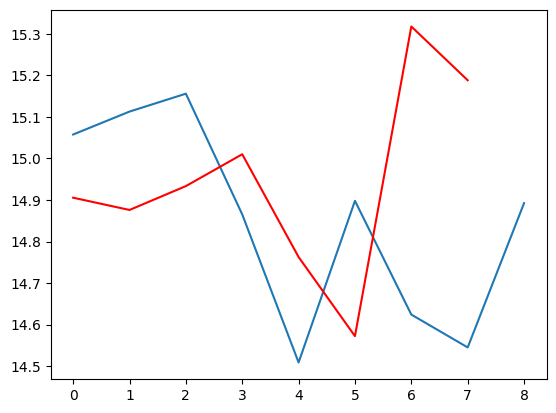

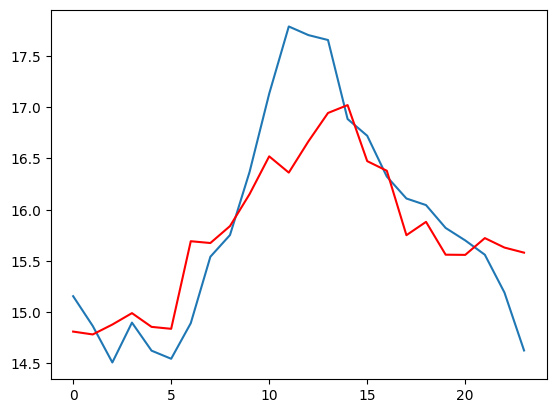

In [71]:
# evaluate forecasts
import math 

rmse = math.sqrt(mean_squared_error(actual_values, p))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(actual_values[0:26:3])
plt.plot(p[1:24:3], color='red')
plt.show()

plt.plot(actual_values[2:72:3])
plt.plot(p[2:72:3], color='red')
plt.show()